# Final Assignment Supervised learning

## information
    Thijs Kok
    348224
    DSLS


## Justification of dataset

I chose to use the parkinsons dataset because:

- It's easily available

- It has documentation about the data

- It's interesting to look at the comparison between vocal data and parkinsons

- I think the dataset is usefull to train classifiers on because it has binary choices (i.e. either 0 or 1)

- My grandmother had parkinsons


## information on the data

Attribute Information:

Matrix column entries (attributes):
- name - ASCII subject name and recording number
- MDVP:Fo(Hz) - Average vocal fundamental frequency
- MDVP:Fhi(Hz) - Maximum vocal fundamental frequency
- MDVP:Flo(Hz) - Minimum vocal fundamental frequency
- MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP - Several 
- measures of variation in fundamental frequency
- MDVP:Shimmer,MDVP:Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,MDVP:APQ,Shimmer:DDA - Several measures of variation in amplitude
- NHR,HNR - Two measures of ratio of noise to tonal components in the voice
- status - Health status of the subject (one) - Parkinson's, (zero) - healthy
- RPDE,D2 - Two nonlinear dynamical complexity measures
- DFA - Signal fractal scaling exponent
- spread1,spread2,PPE - Three nonlinear measures of fundamental frequency variation 

## Choice of algorithms

Since the question we're looking for is the prediction of parkinsons based on vocal recordings, this is a classification problem.

the techniques used will be: 

- logistic regression
- decision trees
- ensemble learning


### Initialisation

In [446]:
import requests as req
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
import sklearn as sk
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.metrics import mean_squared_error
from sklearn.metrics import recall_score



# bokeh imports for the heatmap plotting
#import bokeh and direct the output to the notebook
from bokeh.io import output_notebook
output_notebook()
from bokeh.plotting import figure, show
from bokeh.models import (BasicTicker, ColorBar, ColumnDataSource,
                          LinearColorMapper, PrintfTickFormatter,)
from bokeh.transform import transform
from bokeh.palettes import Viridis256
from bokeh.models import ColumnDataSource


Loading BokehJS ...

### Downloading the data
The data is obtained from: http://archive.ics.uci.edu/ml/machine-learning-databases/parkinsons/parkinsons.data

I got this data from:
*'Exploiting Nonlinear Recurrence and Fractal Scaling Properties for Voice Disorder Detection', 
Little MA, McSharry PE, Roberts SJ, Costello DAE, Moroz IM. 
BioMedical Engineering OnLine 2007, 6:23 (26 June 2007)*

In [447]:
# download the parkingson data from: http://archive.ics.uci.edu/ml/machine-learning-databases/parkinsons/parkinsons.data
try:
    response = req.get('http://archive.ics.uci.edu/ml/machine-learning-databases/parkinsons/parkinsons.data', timeout=2.50)
    with open(file='data/parkinsons.data', mode= 'w', encoding='utf-8') as data_file:
        data_file.write(response.text)
except Exception as e:
    print(f'{e}')

### Load & inspect the data

We know that the 'status' column contains the information wether or not someone has parkinsons.
This will be our 'y' value for the classifiers

In [448]:
data = pd.read_csv('data/parkinsons.data', sep=',')
data.head()

name  MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
0  phon_R01_S01_1      119.992       157.302        74.997         0.00784   
1  phon_R01_S01_2      122.400       148.650       113.819         0.00968   
2  phon_R01_S01_3      116.682       131.111       111.555         0.01050   
3  phon_R01_S01_4      116.676       137.871       111.366         0.00997   
4  phon_R01_S01_5      116.014       141.781       110.655         0.01284   

   MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  ...  \
0           0.00007   0.00370   0.00554     0.01109       0.04374  ...   
1           0.00008   0.00465   0.00696     0.01394       0.06134  ...   
2           0.00009   0.00544   0.00781     0.01633       0.05233  ...   
3           0.00009   0.00502   0.00698     0.01505       0.05492  ...   
4           0.00011   0.00655   0.00908     0.01966       0.06425  ...   

   Shimmer:DDA      NHR     HNR  status      RPDE       DFA   spread1  \
0      0.06545  0.02211  21.033       1  0.414783  0.815285 -4.813031   
1      0.09403  0.01929  19.085       1  0.458359  0.819521 -4.075192   
2      0.08270  0.01309  20.651       1  0.429895  0.825288 -4.443179   
3      0.08771  0.01353  20.644       1  0.434969  0.819235 -4.117501   
4      0.10470  0.01767  19.649       1  0.417356  0.823484 -3.747787   

    spread2        D2       PPE  
0  0.266482  2.301442  0.284654  
1  0.335590  2.486855  0.368674  
2  0.311173  2.342259  0.332634  
3  0.334147  2.405554  0.368975  
4  0.234513  2.332180  0.410335  

[5 rows x 24 columns]

#### check if there are any missing values

In [449]:
print(data.isnull().sum())

name                0
MDVP:Fo(Hz)         0
MDVP:Fhi(Hz)        0
MDVP:Flo(Hz)        0
MDVP:Jitter(%)      0
MDVP:Jitter(Abs)    0
MDVP:RAP            0
MDVP:PPQ            0
Jitter:DDP          0
MDVP:Shimmer        0
MDVP:Shimmer(dB)    0
Shimmer:APQ3        0
Shimmer:APQ5        0
MDVP:APQ            0
Shimmer:DDA         0
NHR                 0
HNR                 0
status              0
RPDE                0
DFA                 0
spread1             0
spread2             0
D2                  0
PPE                 0
dtype: int64


As we can see from the cell above, there appears to be no missing data.


In [450]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195 entries, 0 to 194
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              195 non-null    object 
 1   MDVP:Fo(Hz)       195 non-null    float64
 2   MDVP:Fhi(Hz)      195 non-null    float64
 3   MDVP:Flo(Hz)      195 non-null    float64
 4   MDVP:Jitter(%)    195 non-null    float64
 5   MDVP:Jitter(Abs)  195 non-null    float64
 6   MDVP:RAP          195 non-null    float64
 7   MDVP:PPQ          195 non-null    float64
 8   Jitter:DDP        195 non-null    float64
 9   MDVP:Shimmer      195 non-null    float64
 10  MDVP:Shimmer(dB)  195 non-null    float64
 11  Shimmer:APQ3      195 non-null    float64
 12  Shimmer:APQ5      195 non-null    float64
 13  MDVP:APQ          195 non-null    float64
 14  Shimmer:DDA       195 non-null    float64
 15  NHR               195 non-null    float64
 16  HNR               195 non-null    float64
 1

Let's see if the data is correlated.

In [451]:
c = data.corr().abs()
y_range = (list(reversed(c.columns)))
x_range = (list(c.index))
#plot a heatmap


#reshape
dfc = pd.DataFrame(c.stack(), columns=['r']).reset_index()
#create colormapper 

#transfer to ColumnDataSource object
source = ColumnDataSource(dfc)
mapper = LinearColorMapper(palette=Viridis256, low=dfc.r.min(), high=dfc.r.max())

#create plot
p = figure(title="correlation heatmap", plot_width=500, plot_height=450,
           x_range=x_range, y_range=y_range, x_axis_location="above", toolbar_location=None)

#use mapper to fill the rectangles in the plot
p.rect(x="level_0", y="level_1", width=1, height=1, source=source,
       line_color=None, fill_color=transform('r', mapper))

#create and add colorbar to the right
color_bar = ColorBar(color_mapper=mapper, location=(0, 0),
                     ticker=BasicTicker(desired_num_ticks=len(x_range)), 
                     formatter=PrintfTickFormatter(format="%.1f"))
p.add_layout(color_bar, 'right')

#draw axis
p.axis.axis_line_color = None
p.axis.major_tick_line_color = None
p.axis.major_label_text_font_size = "10px"
p.axis.major_label_standoff = 0
p.xaxis.major_label_orientation = 1.0

#show
show(p)

print(c['status'].sort_values())

MDVP:Fhi(Hz)        0.166136
NHR                 0.189429
DFA                 0.231739
Jitter:DDP          0.266646
MDVP:RAP            0.266668
MDVP:Jitter(%)      0.278220
MDVP:PPQ            0.288698
RPDE                0.308567
MDVP:Jitter(Abs)    0.338653
D2                  0.340232
Shimmer:DDA         0.347608
Shimmer:APQ3        0.347617
MDVP:Shimmer(dB)    0.350697
Shimmer:APQ5        0.351148
HNR                 0.361515
MDVP:APQ            0.364316
MDVP:Shimmer        0.367430
MDVP:Flo(Hz)        0.380200
MDVP:Fo(Hz)         0.383535
spread2             0.454842
PPE                 0.531039
spread1             0.564838
status              1.000000
Name: status, dtype: float64


There are some correlated values in the dataset, but we're most interested in the correlation between 'status' and other parameters.

so far it does not seem that there are highly correlated parameters for the status parameter(no really light or yellow intersections). however, it does appear that most parameters have a correlation of around .3 to .5 with the status parameter.

As we can see, the 'spread1', 'spread2', and 'PPE' have the highest correlation with the status parameter. I will make several different datasets which contain: 
- dataset 1: R > 0.4
- dataset 2: R > 0.3
- dataset 3: == normal dataset, this will be the reference model


We drop the name column and set the status column as the y axis, before dropping it as well.


In [452]:
y = data.status.values

data.drop(['status', 'name'], axis=1, inplace = True)

X_full = data.values


names_high = c[c['status'] > 0.4].index
X_high = data[names_high[1:]].values

names_middle = c[c['status'] > 0.3].index
X_middle = data[names_high[1:]].values


# I took all the code for scaling and selecting features and put it all in a single function.
def feature_selector(data_frame = data, r=1):
    names = c[c['status'] >= r].index
    print(f'The following columns have a correlation score above {r}:\n{names}')
    X = data_frame[names[1:]].values
    print(f'X-shape = {X.shape}, y-shape = {y.shape}')
    scaler = StandardScaler()
    scaler = scaler.fit(X)
    X = scaler.transform(X)
    return train_test_split(X, y, test_size=0.3, random_state=1)


In [453]:
print(f'X-shape = {X_full.shape}, y-shape = {y.shape}')

X-shape = (195, 22), y-shape = (195,)


As we can see, y has the shape '195,' which needs to be reshaped to be '195,1'

In [454]:
y = y.reshape(-1,1)

In [455]:
y.shape

(195, 1)

Now we need to normalize the data to prevent higher numbers to affect the outcome of the algorithms. 

For this i use the standardscaler from scikit-learn

In [456]:
scaler = StandardScaler()
scaler = scaler.fit(X_full)
X_full = scaler.transform(X_full)

scaler = StandardScaler()
scaler = scaler.fit(X_middle)
X_middle = scaler.transform(X_middle)

scaler = StandardScaler()
scaler = scaler.fit(X_high)
X_high = scaler.transform(X_high)

Now that the data is scaled we split the data into training data and into test data! for this we use a 70/30 ratio, so we have a decent amount of data to test with while still keeping enough to teach the algorithm

In [457]:
X_full_train, X_full_test, y_train, y_test = train_test_split(X_full, y, test_size=0.3, random_state=1)
X_high_train, X_high_test, y_train, y_test = train_test_split(X_high, y, test_size=0.3, random_state=1)
X_middle_train, X_middle_test, y_train, y_test = train_test_split(X_middle, y, test_size=0.3, random_state=1)

## Training the models

logistic regression:


In [458]:
def model(X, y):
    '''
    model the data using logistic regression
    parameters: 
        X = X_train > training data

        y = y_train > training data
    '''
    # first normalize the data
    clf = LogisticRegression(random_state=42).fit(X, y)
    return clf


full_model = model(X_full_train, y_train)
high_model = model(X_high_train, y_train)
middle_model = model(X_middle_train, y_train)


c:\Users\thijs\anaconda3\envs\supervised_machine_learning_ds4\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\thijs\anaconda3\envs\supervised_machine_learning_ds4\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\thijs\anaconda3\envs\supervised_machine_learning_ds4\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


compare the scores of the models! now we;ve trained the models we want to get the scores

In [459]:
print(f'the full model has a score of: {full_model.score(X_full_test, y_test):.5f}')
print(f'the high model has a score of: {high_model.score(X_high_test, y_test):.5f}')
print(f'the middle model has a score of: {middle_model.score(X_middle_test, y_test):.5f}')

the full model has a score of: 0.81356
the high model has a score of: 0.79661
the middle model has a score of: 0.79661


In [460]:
def plot_learning_curves(model, X_train, y_train, X_val, y_val):
    """
    input:
        model:pipeline object
        X_train, y_train: training data
        X_val, y_val: test data
    """
    train_errors, val_errors = [], []
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train_predict, y_train[:m]))
        val_errors.append(mean_squared_error(y_val_predict, y_val))

    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="training data")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="validation data")
    plt.legend(loc="upper right", fontsize=14)   
    plt.xlabel("Training set size", fontsize=14) 
    plt.ylabel("RMSE", fontsize=14)     
    return 0

In [461]:
def voting(X_full, X_middle, X_high):
    '''
    Voting algorithm (hard) for the 3 classifiers.
    parameters:
        X_full = sample containing all the features

        X_ middle = dataset containing only the features with a correlation > 0.3 to the 
                    status feature
        
        X_high = dataset containing only the features with a correlation > 0.4 to the 
                 status feature
        
        returns: 

            1 or 0, depending on the voting (1=ill, 0 = healthy)
    '''
    full = full_model.predict(X_full)[0]
    middle = middle_model.predict(X_middle)[0]
    high = high_model.predict(X_high)[0]
    full_prob = full_model.predict_proba(X_full)[0][0]
    middle_prob = middle_model.predict_proba(X_middle)[0][0]
    high_prob = high_model.predict_proba(X_high)[0][0]
    print('predictions:')
    print(f'full model: {full}, probability = {full_prob:.3e}\nmiddle: {middle} probability = {middle_prob:.3e}\nhigh: {high} probability = {high_prob:.3e}')
    tmp = []
    # return the final score of the models. 
    score = (full+middle+high) / 3
    if score == 1.0:
        tmp.append(1)
    elif score == 2/3:
        tmp.append(1)
    else:
        tmp.append(0)
    return np.array(tmp)
    
voting(X_full[1:10], X_middle[1:10], X_high[1:10])

predictions:
full model: 1, probability = 1.962e-04
middle: 1 probability = 1.259e-03
high: 1 probability = 1.259e-03


array([1])

### Decision tree

The decision tree will be trained using the full dataset.

test  acc: 0.8135593220338984
train acc: 0.8897058823529411


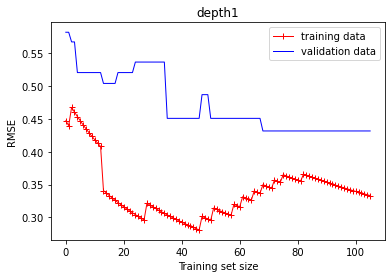

test  acc: 0.7627118644067796
train acc: 0.9117647058823529


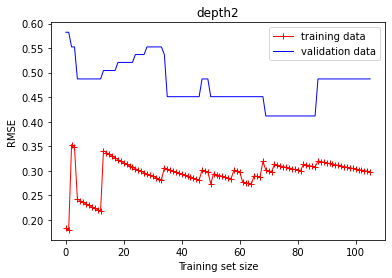

test  acc: 0.7796610169491526
train acc: 0.9705882352941176


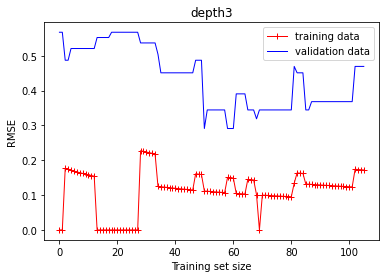

test  acc: 0.7966101694915254
train acc: 0.9779411764705882


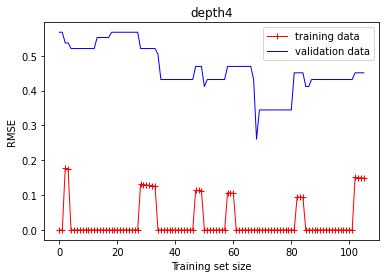

test  acc: 0.864406779661017
train acc: 1.0


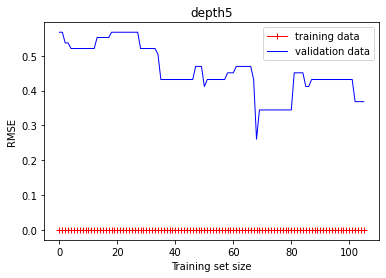

test  acc: 0.864406779661017
train acc: 1.0


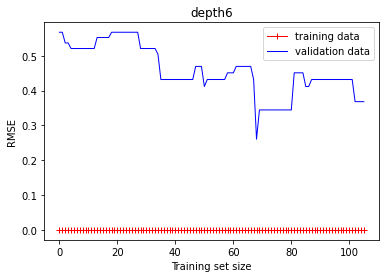

In [476]:
def plot_reg_tree(X, x_pred, Y, y_pred, title):
    plt.plot(X, y, "b.")
    plt.plot(x_pred, y_pred, "r.-", linewidth=2, label=r"$\hat{y}$")
    plt.axis([0, 1, -0.2, 1.1])
    plt.xlabel("$x_1$", fontsize=18)
    plt.ylabel("$y$", fontsize=18, rotation=0)
    plt.legend(loc="upper center", fontsize=18)
    plt.title(title, fontsize=14)

def plot_learning_curves(model, X_train, y_train, X_val, y_val):
    """
    input:
        model:pipeline object
        X_train, y_train: training data
        X_val, y_val: test data
    """
    train_errors, val_errors = [], []
    for m in range(30, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train_predict, y_train[:m]))
        val_errors.append(mean_squared_error(y_val_predict, y_val))

    plt.plot(np.sqrt(train_errors), "r-+", linewidth=1, label="training data")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=1, label="validation data")
    plt.legend(loc="upper right", fontsize=10)   
    plt.xlabel("Training set size", fontsize=10) 
    plt.ylabel("RMSE", fontsize=10)     
    # compare accuracy train versus test to access overfit 
    print(f'test  acc: {model.score(X_val, y_val)}')
    print(f'train acc: {model.score(X_train, y_train)}')

for depths in range(1, 7):
    plot_learning_curves(DecisionTreeClassifier(max_depth=depths, random_state=42),X_full_train, y_train, X_full_test, y_test )
    plt.title(f'depth{depths}');plt.show()

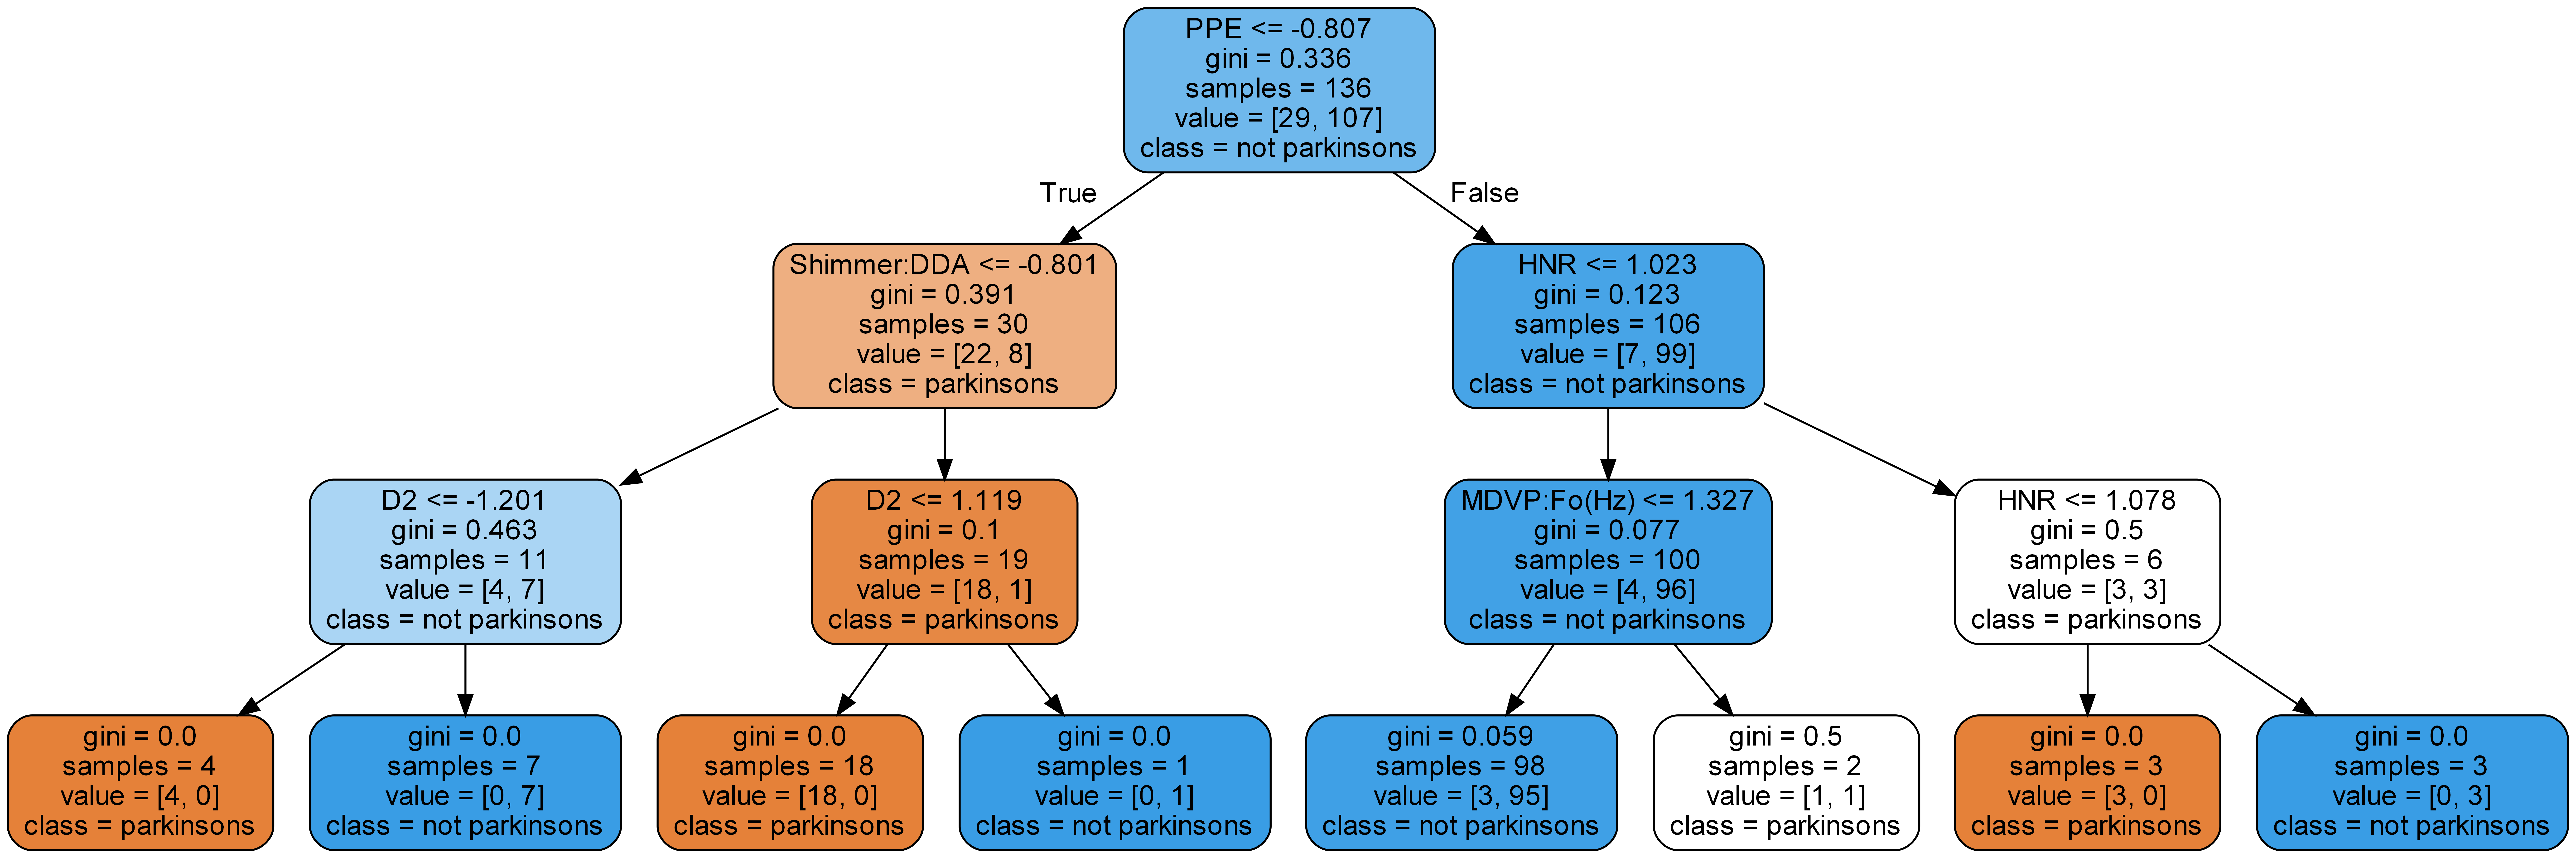

In [463]:
tree_clf_three = DecisionTreeClassifier(max_depth=3, random_state=42)
tree_clf_three.fit(X_full_train, y_train)

export_graphviz(
        tree_clf_three,
        out_file="parskinsons1.dot",
        feature_names=data.columns,
        class_names=['parkinsons', 'not parkinsons'],
        rounded=True,
        filled=True
    )

from subprocess import call
# You probably need to change the path to your own installation of graphviz
call(['C:\Program Files\Graphviz/bin/dot', '-Tpng', 'parskinsons1.dot', '-o', 'parskinsons1.png', '-Gdpi=600'])

from IPython.display import Image
Image(filename = 'parskinsons1.png')

as we can see in the decision tree above, the gini scores of some of the features are still quite high (0.5) while the other gini scores are all 0, this might mean that the model is overfitting for these features and underfitting for the other features.

However, we will see what happens if more depth is introduced

In [464]:
tree_clf_four = DecisionTreeClassifier(max_depth=4, random_state=42)
tree_clf_four.fit(X_full_train, y_train)

export_graphviz(
        tree_clf_four,
        out_file="parskinsons2.dot",
        feature_names=data.columns,
        class_names=['parkinsons', 'not parkinsons'],
        rounded=True,
        filled=True
    )

from subprocess import call
# You probably need to change the path to your own installation of graphviz
call(['C:\Program Files\Graphviz/bin/dot', '-Tpng', 'parskinsons2.dot', '-o', 'parskinsons2.png', '-Gdpi=600'])

from IPython.display import Image
Image(filename = 'parskinsons2.png')

as we can discern from the image above, there still is one leaf with a 'high' gini score. if we go one level deeper it will probably be gone

In [465]:
tree_clf_five = DecisionTreeClassifier(max_depth=5, random_state=42)
tree_clf_five.fit(X_full_train, y_train)

export_graphviz(
        tree_clf_five,
        out_file="parskinsons3.dot",
        feature_names=data.columns,
        class_names=['parkinsons', 'not parkinsons'],
        rounded=True,
        filled=True
    )

from subprocess import call
# You probably need to change the path to your own installation of graphviz
call(['C:\Program Files\Graphviz/bin/dot', '-Tpng', 'parskinsons3.dot', '-o', 'parskinsons3.png', '-Gdpi=600'])

from IPython.display import Image
Image(filename = 'parskinsons3.png')

as we can see in the above image, a decisiontree with a depth of 5 will predict all the cases with a gini of 0. however, this model is probably completely overfitted.
We will check this using the scores.

depth:
3: 0.7796610169491526
4: 0.7966101694915254
5: 0.864406779661017
test  acc: 0.7966101694915254
train acc: 0.9779411764705882


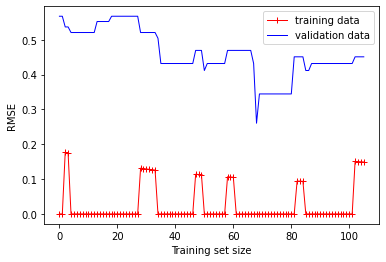

In [468]:
score_three = tree_clf_three.score(X_full_test, y_test)
score_four = tree_clf_four.score(X_full_test, y_test)
score_five = tree_clf_five.score(X_full_test, y_test)

print(f'depth:\n3: {score_three}\n4: {score_four}\n5: {score_five}')



as seen from the score, it seems that the classifier with a depth of 5 has the highest score.
This means that this model predicts the data the best and that the other two models are prpbably underfitted.


## Ensembling the models

The logistic regression model with the full dataset describes the data best so this will be used in the voting algorithm.
Furthermore, the decision tree with a depth of 5 will be used since it has the best accuracy of the three decision tree models

In [467]:
m,n = y_train.shape

# i use the soft voting since this takes the probabilities into account.
eclf = VotingClassifier(
    estimators=[('lg', high_model), ('dt', tree_clf_five)],
    voting='soft').fit(X_full_train, y_train.reshape(m))
m,n = y_test.shape
for clf, label in zip([high_model, tree_clf_five, eclf], ['Logistic regression', 'Decision tree', 'Ensemble']):
    scores = cross_val_score(clf, X_full_test, y_test.reshape(m), scoring='accuracy', cv=5)
    print("Accuracy: %0.3f (+/- %0.3f) [%s]" % (scores.mean(), scores.std(), label))



print(f'recall decision tree: {recall_score(y_test, tree_clf_five.predict(X_full_test))}')
print(f'recall logistic reg: {recall_score(y_test, full_model.predict(X_full_test))}')
print(f'recall ensemble: {recall_score(y_test, eclf.predict(X_full_test))}')

Accuracy: 0.814 (+/- 0.032) [Logistic regression]
Accuracy: 0.748 (+/- 0.089) [Decision tree]
Accuracy: 0.748 (+/- 0.089) [Ensemble]
recall decision tree: 0.95
recall logistic reg: 0.925
recall ensemble: 0.95


## Conclusion


As we can see, the ensemble model does not outperform the individual models in each metric.
However, the ensemble model does perform the same as the decision tree when looking at the accuracy of the model it also performs worse than the logistic regression model.
Moreover, the ensembled model does outperform the logistic regression model in the case of recall. 

- Overall this model predicts wheter or not the subject has parkinsons right for 95 % percent of the time. which is what we want since it's better to have a little more false positives and more true positives than false negatives if we want to treat a subject.

- all individual models could be improved by hyperparameter tuning, or regularisation. 
The ensemble model can be improved (i think) by including more models that are available, for example extreme gradient boost or a naive bayes algorithm.

Due to time contraints that was not performed in this notebook. 